<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/xgb_aki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model to Predict Postoperative Acute Kidney Injury
In this example, we will learn how to build a model for predicting postoperative acute kidney injury (AKI) using <code>xgboost</code> and <code>VitalDB</code> dataset.

In [ ]:
!pip install -q xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

In [ ]:
# Load datasets
df = pd.read_csv('https://api.vitaldb.net/cases')
df['sex'] = (df['sex'] == 'M')

# Load labs
df_labs = pd.read_csv('https://api.vitaldb.net/labs')
df_labs = df_labs.loc[df_labs.name == 'cr']

# postop creatinine level within 7 days after surgery
df_labs = pd.merge(df, df_labs, on='caseid', how='left')
df_labs = df_labs.loc[df_labs.dt > df_labs.opend]
df_labs = df_labs.loc[df_labs.dt < df_labs.opend + 7 * 3600 * 24]
df_labs = df_labs.groupby('caseid')['result'].max().reset_index()
df_labs.groupby('caseid')['result'].max().reset_index()
df_labs.rename(columns={'result':'postop_cr'}, inplace=True)

df = pd.merge(df, df_labs, on='caseid', how='left')
df.dropna(subset=['preop_cr', 'postop_cr'], inplace=True)

df

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca,postop_cr
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,120,0.0,100,70,0,10,0,0,0,0.91
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,150,0.0,0,100,0,20,0,0,0,1.02
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,80,0.0,100,100,0,50,0,0,0,0.87
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0.0,0,160,0,10,900,0,2100,4.43
9,10,2175,0,20992,-1743,21057.0,2457,19857,-220740,3580860,...,90,0.0,0,110,0,20,500,0,600,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382,6383,4255,0,23242,-1883,23137.0,3037,22641,-224040,812760,...,0,0.0,0,80,0,10,0,0,300,6.14
6383,6384,5583,0,15248,-260,15640.0,2140,14140,-215340,648660,...,150,0.0,0,90,0,20,0,0,0,1.07
6384,6385,2278,0,20643,-544,20996.0,2396,19496,-225600,1675200,...,100,0.0,0,100,0,25,30,0,300,1.14
6385,6386,4045,0,19451,-667,19133.0,3533,18233,-200460,836340,...,70,0.0,0,130,0,10,0,0,0,0.62


In [ ]:
# Remove categorical variables
df = df.drop(columns=['department','optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'lmasize', 'preop_ecg', 'preop_pft', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2'])
df = df.astype(float)

# KDIGO stage I
df['aki'] = df['postop_cr'] > df['preop_cr'] * 1.5

# Remove outcome variables
y = df['aki'].values.flatten()
df['andur'] = df['aneend'] - df['anestart']
df = df.drop(columns=['aki', 'postop_cr', 'death_inhosp','caseid','subjectid','icu_days','casestart','caseend','anestart','aneend','opstart','opend','adm','dis'])

# Input variables
x = df.values

x

array([[7.700e+01, 1.000e+00, 1.602e+02, ..., 0.000e+00, 0.000e+00,
        1.140e+04],
       [5.400e+01, 1.000e+00, 1.673e+02, ..., 0.000e+00, 0.000e+00,
        1.596e+04],
       [7.400e+01, 1.000e+00, 1.606e+02, ..., 0.000e+00, 0.000e+00,
        2.100e+04],
       ...,
       [6.900e+01, 1.000e+00, 1.593e+02, ..., 0.000e+00, 3.000e+02,
        2.154e+04],
       [6.100e+01, 0.000e+00, 1.517e+02, ..., 0.000e+00, 0.000e+00,
        1.980e+04],
       [2.400e+01, 0.000e+00, 1.557e+02, ..., 0.000e+00, 0.000e+00,
        1.338e+04]])

In [ ]:
# Split a dataset into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

# Gradient Boosting Machine
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss')
model.fit(x_train, y_train)
y_pred_gbm = model.predict_proba(x_test)[:, 1]

166/3191 (5.20%) train, 44/798 (5.51%) test, 43 features


GBM auroc: 0.822, auprc: 0.360


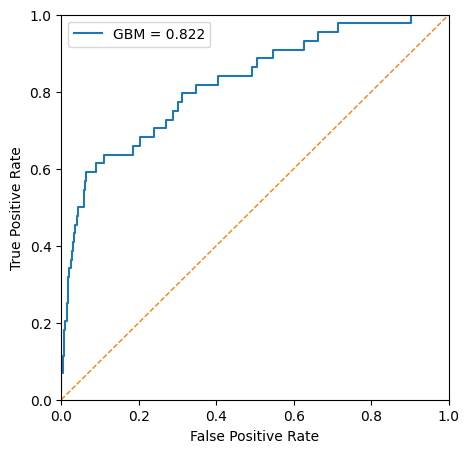

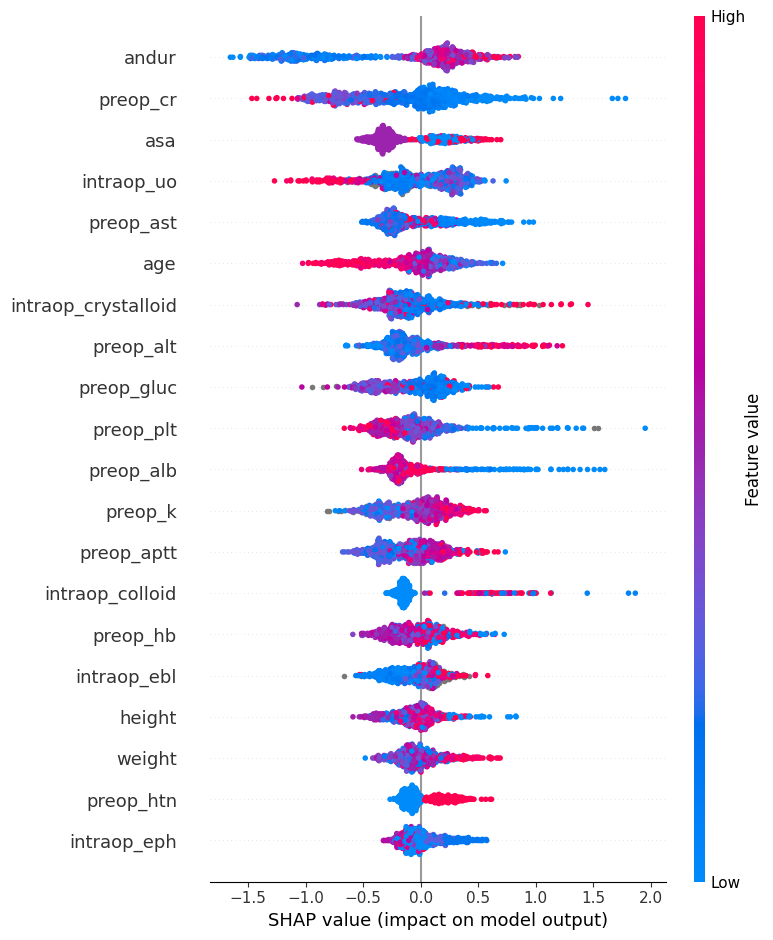

In [ ]:
# Compute AUROC and AUPRC
auroc_gbm = roc_auc_score(y_test, y_pred_gbm)
prc_gbm, rec_gbm, thresholds = precision_recall_curve(y_test, y_pred_gbm)
auprc_gbm = auc(rec_gbm, prc_gbm)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)
print(f'GBM auroc: {auroc_gbm:.3f}, auprc: {auprc_gbm:.3f}', flush=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(fpr_gbm, tpr_gbm, label='GBM = {:0.3f}'.format(auroc_gbm))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('auroc.png')

import shap
explainer = shap.TreeExplainer(model)
plt.figure(figsize=(5, 5))
shap.summary_plot(explainer.shap_values(x_test, y_test), x_test, feature_names=df.columns, show=False)  # , max_display=10
plt.savefig('shap.png')